In [1]:
import pandas as pd
import pytz
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
url = 'https://raw.githubusercontent.com/asimxa/Data-Diggers-Project-Repo/refs/heads/main/resources/charging_sessions_cleaned.csv'
df = pd.read_csv(url)


In [3]:
df.columns

Index(['id', 'connectionTime', 'disconnectTime', 'doneChargingTime',
       'kWhDelivered', 'sessionID', 'siteID', 'spaceID', 'stationID', 'userID',
       'minutesAvailable', 'milesRequested', 'modifiedAt',
       'requestedDeparture', 'kWhRequested', 'WhPerMile', 'connectionDuration',
       'chargingDuration', 'noChargingTime', 'kWh_delivered_requested_diff'],
      dtype='object')

In [4]:
df.dtypes

,0
id,object
connectionTime,object
disconnectTime,object
doneChargingTime,object
kWhDelivered,float64
sessionID,object
siteID,int64
spaceID,object
stationID,object
userID,float64


In [5]:
df['connectionTime'] = pd.to_datetime(df['connectionTime'], utc=True, errors='coerce')
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'], utc=True, errors='coerce')
df['doneChargingTime'] = pd.to_datetime(df['doneChargingTime'], utc=True, errors='coerce')
df['requestedDeparture'] = pd.to_datetime(df['requestedDeparture'], utc=True, errors='coerce')
df['connectionDuration'] = pd.to_timedelta(df['connectionDuration'])
df['chargingDuration'] = pd.to_timedelta(df['chargingDuration'])
df['noChargingTime']  = pd.to_timedelta(df['noChargingTime'])

In [6]:

# Convert 'connectionTime', 'disconnectTime', and 'doneChargingTime' to datetime objects
for col in ['connectionTime', 'disconnectTime', 'doneChargingTime']:
    df[col] = pd.to_datetime(df[col])

# Specify the target timezone
la_tz = pytz.timezone('America/Los_Angeles')

# Convert to Los Angeles timezone
for col in ['connectionTime', 'disconnectTime', 'doneChargingTime']:
    df[col] = df[col].dt.tz_convert(la_tz)

In [7]:
df.dtypes

,0
id,object
connectionTime,"datetime64[ns, America/Los_Angeles]"
disconnectTime,"datetime64[ns, America/Los_Angeles]"
doneChargingTime,"datetime64[ns, America/Los_Angeles]"
kWhDelivered,float64
sessionID,object
siteID,int64
spaceID,object
stationID,object
userID,float64


We'll start with some exploration. First, we standardize data. For the clustering algorithm to run correctly, we have to drop rows with NaN values

> Blockzitat einfügen



In [8]:
features = ["connectionDuration",
            "chargingDuration",
            "noChargingTime",
            "kWhDelivered",
            "kWh_delivered_requested_diff"]

X = df[features].copy()

# Drop rows with any missing values
X.dropna(inplace=True)
# Convert timedelta64 columns to seconds
for col in ["connectionDuration", "chargingDuration", "noChargingTime"]:
    X[col] = X[col].dt.total_seconds()  # Access dt accessor and use total_seconds()


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Now we'll take a look at the Elbow plot

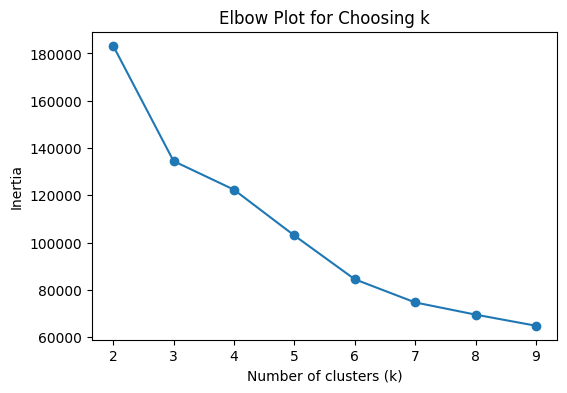

In [9]:
inertia_list = []
k_values = range(2, 10)  # test k from 2 to 9
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia_list.append(kmeans.inertia_)


plt.figure(figsize=(6, 4))
plt.plot(k_values, inertia_list, marker='o')
plt.title('Elbow Plot for Choosing k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.show()

k=6 seems to be good, but for the fact that our recipients of the report are not necessarily data experts, we also aim for easy understandable modeling of clusters. Thus, we also take a look at k=3 and then compare

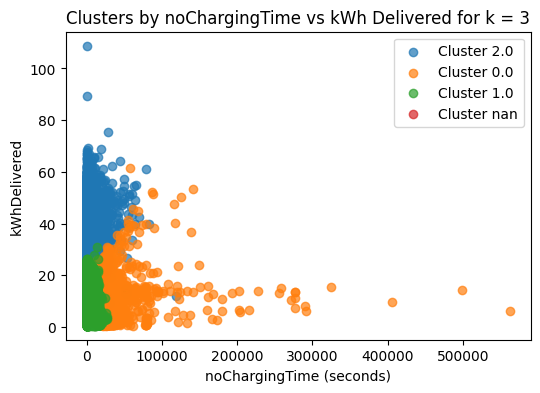

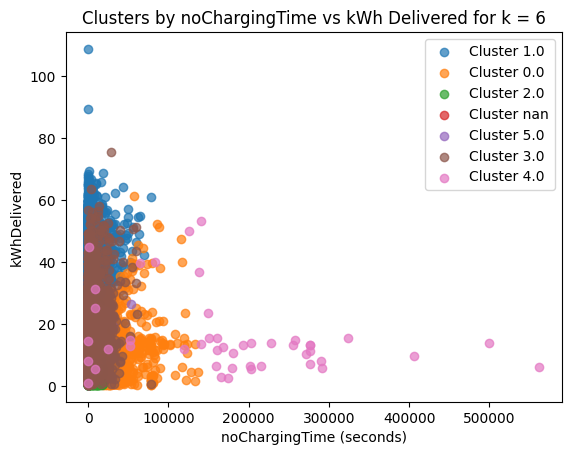

In [10]:
import matplotlib.pyplot as plt

# Let's do a simple 2D scatter by two features
feature_x = "noChargingTime"
feature_y = "kWhDelivered"

plt.figure(figsize=(6, 4))


#-----k = 3--------
k_opt = 3
X_3 = X
X_scaled_3 = scaler.fit_transform(X_3)
kmeans_opt = KMeans(n_clusters=k_opt, random_state=42)
kmeans_opt.fit(X_scaled_3)

# Instead of assigning to df directly, create a new 'cluster' column in X

X_3['cluster_X3'] = kmeans_opt.labels_

# Merge the cluster labels back into the original DataFrame based on index
df = df.merge(X_3[['cluster_X3']], left_index=True, right_index=True, how='left')




# Merge the cluster labels back into the original DataFrame based on index
#df = df.merge(X_6[['cluster_X6']], left_index=True, right_index=True, how='left')
# We'll plot each cluster in a loop
for cluster_label in df['cluster_X3'].unique():
    cluster_data = df[df['cluster_X3'] == cluster_label]
    # Convert 'chargingDuration' to total seconds for plotting
    plt.scatter(
        cluster_data[feature_x].dt.total_seconds(),  # Convert to numeric (seconds)
        cluster_data[feature_y],
        label=f"Cluster {cluster_label}",
        alpha=0.7
    )

plt.title("Clusters by noChargingTime vs kWh Delivered for k = 3")
plt.xlabel(feature_x + " (seconds)") # Update x-axis label
plt.ylabel(feature_y)
plt.legend()
plt.show()
#------------for k=6--------
k_opt = 6
X_6 = X
X_scaled_6 = scaler.fit_transform(X_6)
kmeans_opt = KMeans(n_clusters=k_opt, random_state=42)
kmeans_opt.fit(X_scaled_6)
# Instead of assigning to df directly, create a new 'cluster' column in X
X_6['cluster_X6'] = kmeans_opt.labels_
df = df.merge(X_6[['cluster_X6']], left_index=True, right_index=True, how='left')

for cluster_label in df['cluster_X6'].unique():
    cluster_data = df[df['cluster_X6'] == cluster_label]
    # Convert 'chargingDuration' to total seconds for plotting
    plt.scatter(
        cluster_data[feature_x].dt.total_seconds(),  # Convert to numeric (seconds)
        cluster_data[feature_y],
        label=f"Cluster {cluster_label}",
        alpha=0.7
    )

plt.title("Clusters by noChargingTime vs kWh Delivered for k = 6")
plt.xlabel(feature_x + " (seconds)") # Update x-axis label
plt.ylabel(feature_y)
plt.legend()
plt.show()

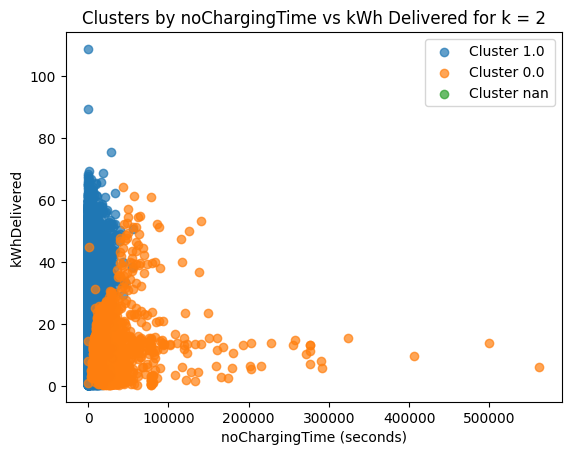

In [11]:
#------------for k=2--------
k_opt = 2
X_2 = X
X_scaled_2 = scaler.fit_transform(X_2)
kmeans_opt = KMeans(n_clusters=k_opt, random_state=42)
kmeans_opt.fit(X_scaled_2)
# Instead of assigning to df directly, create a new 'cluster' column in X
X_6['cluster_X2'] = kmeans_opt.labels_
df = df.merge(X_6[['cluster_X2']], left_index=True, right_index=True, how='left')

for cluster_label in df['cluster_X2'].unique():
    cluster_data = df[df['cluster_X2'] == cluster_label]
    # Convert 'chargingDuration' to total seconds for plotting
    plt.scatter(
        cluster_data[feature_x].dt.total_seconds(),  # Convert to numeric (seconds)
        cluster_data[feature_y],
        label=f"Cluster {cluster_label}",
        alpha=0.7
    )

plt.title("Clusters by noChargingTime vs kWh Delivered for k = 2")
plt.xlabel(feature_x + " (seconds)") # Update x-axis label
plt.ylabel(feature_y)
plt.legend()
plt.show()